In [1]:
import sys
sys.path.append("..")
sys.path.append("../../../..")
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
from argparse import Namespace
from absl import app
from absl import flags
import numpy as np
import PIL
import tensorflow as tf
from tensorflow_gan.examples.cyclegan import data_provider
from tensorflow_gan.examples.cyclegan import networks
import json

In [5]:
def _make_dir_if_not_exists(dir_path):
    """Make a directory if it does not exist."""
    if not tf.io.gfile.exists(dir_path):
        tf.io.gfile.makedirs(dir_path)

def _file_output_path(dir_path, input_file_path):
    """Create output path for an individual file."""
    return os.path.join(dir_path, os.path.basename(input_file_path))

def make_inference_graph(model_name, patch_dim):
    """Build the inference graph for either the X2Y or Y2X GAN.

    Args:
      model_name: The var scope name 'ModelX2Y' or 'ModelY2X'.
      patch_dim: An integer size of patches to feed to the generator.

    Returns:
      Tuple of (input_placeholder, generated_tensor).
    """
    input_hwc_pl = tf.compat.v1.placeholder(tf.float32, [None, None, 3])

    # Expand HWC to NHWC
    images_x = tf.expand_dims(
        data_provider.full_image_to_patch(input_hwc_pl, patch_dim), 0)

    with tf.compat.v1.variable_scope(model_name):
        with tf.compat.v1.variable_scope('Generator'):
            generated = networks.generator(images_x)
    return input_hwc_pl, generated

def export(sess, input_pl, output_tensor, input_file_pattern, output_dir):
    """Exports inference outputs to an output directory.

    Args:
      sess: tf.Session with variables already loaded.
      input_pl: tf.Placeholder for input (HWC format).
      output_tensor: Tensor for generated outut images.
      input_file_pattern: Glob file pattern for input images.
      output_dir: Output directory.
    """
    if output_dir:
        _make_dir_if_not_exists(output_dir)

    result = {}
    if input_file_pattern:
        for file_path in tf.io.gfile.glob(input_file_pattern):
            filename = file_path.split("/")[-1]
            # Grab a single image and run it through inference
            input_np = np.asarray(PIL.Image.open(file_path))
            output_np = sess.run(output_tensor, feed_dict={input_pl: input_np})
            image_np = data_provider.undo_normalize_image(output_np)
            generated_filename = "generated_from_" + filename
            result[filename] = image_np
            if (output_dir):
                output_path = _file_output_path(output_dir, generated_filename)
                print("output: {output_path}".format(output_path=output_path))
                PIL.Image.fromarray(image_np).save(output_path)
        return result
    
def check_input_info(input_json):
    if (not 'checkpoint_path' in input_json): raise Exception("Please provide model checkpoint.")
    
    if ("x2y_images_dir" in input_json):
        input_json.x2y_images_dir = input_json.output_dir + input_json.x2y_images_dir
        
    if ("y2x_images_dir" in input_json):
        input_json.y2x_images_dir = input_json.output_dir + input_json.y2x_images_dir
    
    if ("x_images" in input_json and not "x2y_images_dir" in input_json):
        raise Exception("Please provide output dir for y: x-->y.")

    if ("y_images" in input_json and not "y2x_images_dir" in input_json):
        raise Exception("Please provide output dir for x: y-->x.")

In [6]:
input_json = {
    # "checkpoint_path": "/Users/ptien/tfds-download/models_ckpts/tfgan_logdir/cyclegan/model.ckpt-489180",
    # "checkpoint_path":"/Users/ptien/tfds-download/models_ckpts/tfgan_logdir/h2z/cyclegan/model.ckpt-500000", 
    # "train_data_sourec": "cycle_gan/horse2zebra",
    "checkpoint_path": "/Users/shengms/Code/cyclegan_long/model.ckpt-100000",
    "train_data_sourec": "apple2orange",
    # "x_images": "./testdata/*.jpg",
    # "x_images": "/Users/ptien/tfds-download/apple2orange/testA/*.jpg", # "n07740461_10011.jpg",
    "x_images": "/Users/ptien/tfds-download/apple2orange/testA/*.jpg",
    # "x2y_images_dir": "./testdata/tmp2/generated_y/",  # x2y: transform x to y.
    "output_dir": "/Users/ptien/tfds-download/apple2orange/experiment-1000/",
    "x2y_images_dir": "generated_y/", # sub folder under output_dir
    # "y_images": "./testdata/*.jpg",
    # "y2x_images_dir": "./testdata/tmp/generated_x/",  # y2x: transform y to x.
    "patch_size": 256,
}
if (type(input_json) !=Namespace):
    input_json = Namespace(**input_json)

In [7]:
# if not tf.io.gfile.exists(inputs.output_dir):
#     tf.io.gfile.makedirs(inputs.output_dir)

# with open(inputs.output_dir + 'evaluation.json', 'w') as fp:
#     json.dump(input_json.__dict__, fp, indent=4)

print("evluation result: {x}".format(x=input_json.output_dir))
check_input_info(input_json)
images_x_hwc_pl, generated_y = make_inference_graph('ModelX2Y', input_json.patch_size)
# images_y_hwc_pl, generated_x = make_inference_graph('ModelY2X', input_json.patch_size)

evluation result: /Users/ptien/tfds-download/apple2orange/experiment-1000/
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


In [8]:
ds = tfds.load('cycle_gan')
examples = list(tfds.as_numpy(ds['testA'].take(10)))


INFO:tensorflow:Restoring parameters from /Users/shengms/Code/cyclegan_long/model.ckpt-100000


INFO:tensorflow:Restoring parameters from /Users/shengms/Code/cyclegan_long/model.ckpt-100000


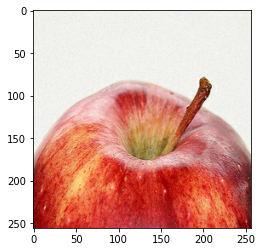

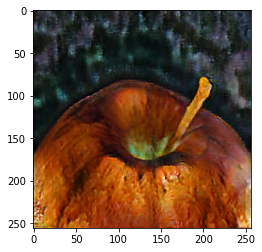

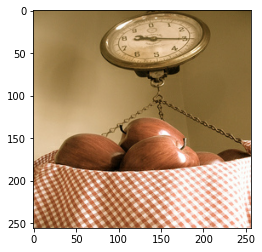

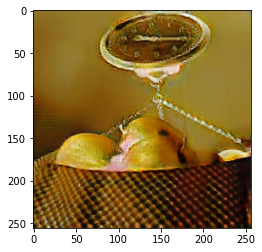

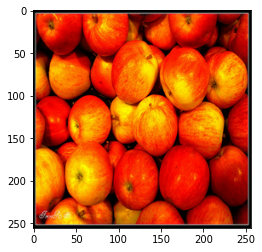

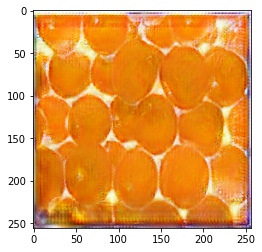

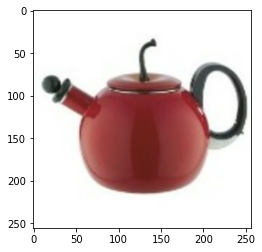

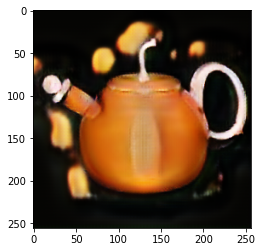

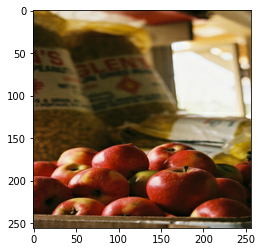

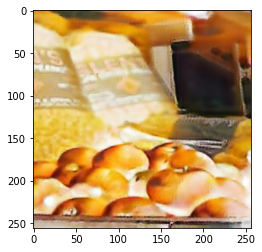

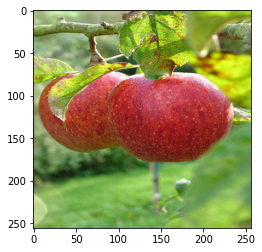

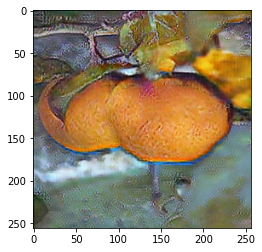

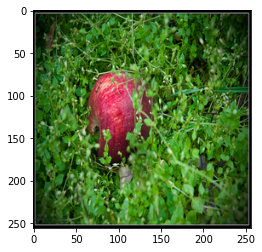

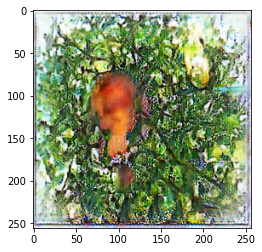

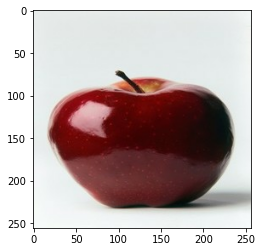

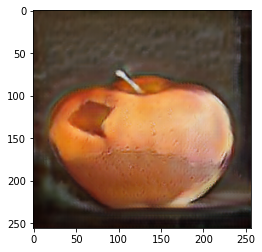

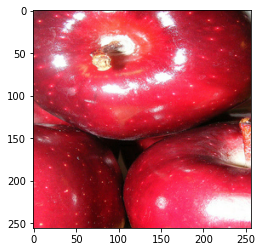

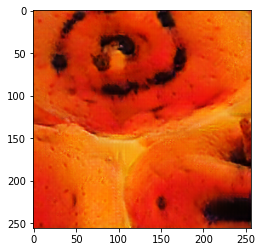

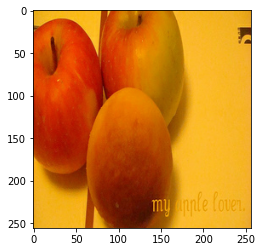

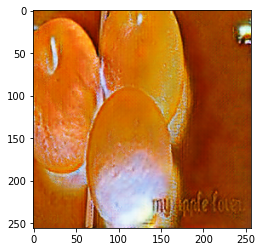

In [9]:

saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    saver.restore(sess, input_json.checkpoint_path)
    for example in examples:
        input_np = example['image']
        output_np = sess.run(generated_y, feed_dict={images_x_hwc_pl: input_np})
        image_np = data_provider.undo_normalize_image(output_np)
        plt.imshow(input_np)
        plt.show()
        plt.imshow(image_np)
        plt.show()
    
#     generated_images_y = export(sess, images_x_hwc_pl, generated_y, inputs.x_images, inputs.x2y_images_dir)
    
#     for file_path in tf.io.gfile.glob(input_file_pattern):
#             filename = file_path.split("/")[-1]
#             # Grab a single image and run it through inference
#             input_np = np.asarray(PIL.Image.open(file_path))
#             output_np = sess.run(output_tensor, feed_dict={input_pl: input_np})
#             image_np = data_provider.undo_normalize_image(output_np)
#             generated_filename = "generated_from_" + filename
#             result[filename] = image_np
#             if (output_dir):
#                 output_path = _file_output_path(output_dir, generated_filename)
#                 print("output: {output_path}".format(output_path=output_path))
#                 PIL.Image.fromarray(image_np).save(output_path)
#         return result